### Download and Plot the Latest US Treasury Bonds Yield Curve

In [121]:
import pandas as pd
import plotly.express as px
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

### Helper Functions

In [122]:
def find_crossings(series1, series2):
    # Find the crossings of Series 1 and Series 2
    crossing_series = pd.Series([0] * len(series1), index=series1.index)
    for i in range(1, len(series1)):
        if ((series1.iloc[i-1] < series2.iloc[i-1]) and (series1.iloc[i] >= series2.iloc[i])):
            crossing_series.iloc[i] = 1
        elif ((series1.iloc[i-1] >= series2.iloc[i-1]) and (series1.iloc[i] < series2.iloc[i])):
            crossing_series.iloc[i] = -1

    # print(series2)
    cross_up = []
    cross_down = []
    for i in series1.index: 
        if crossing_series.loc[i] == 1 : 
            cross_up.append(series1.loc[i])
            cross_down.append(np.nan)
        elif crossing_series.loc[i] == -1:
            cross_down.append(series1.loc[i])
            cross_up.append(np.nan)
        else:
            cross_down.append(np.nan)
            cross_up.append(np.nan)
        

    return crossing_series,cross_up,cross_down

def plot_crossing_series(series1,series2,crossed_up,crossed_down):
    ax = series1.plot(figsize=(15,6))
    ax.grid(True)
    series2.plot(ax=ax)
    
    # Plot the corressing up and down
    ax.plot(series1.index,crossed_up,marker='^',color='green', 
                markersize = 12, linewidth = 0, label = f'{series1.name} Crossed Up')
    ax.plot(series1.index,crossed_down,marker='v',color='red', 
                    markersize = 12, linewidth = 0, label = f'{series1.name} Crossed Down')
    ax.legend()
    ax.grid(which='both')

In [123]:
last_five_years = [str(int(datetime.date.today().year) - i) for i in range(0, 6)]
this_year = last_five_years[0]

### Get Latest Bond Yield Data from US Dept. of Treasury

In [129]:
import time

yield_curves = pd.DataFrame()
yield_curves_diff = pd.DataFrame()

for i in range(len(last_five_years)):
    ustd_url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/"+last_five_years[i]+"/all?type=daily_treasury_yield_curve&field_tdr_date_value="+last_five_years[i]+"&page&_format=csv"
    yield_curve_df = pd.read_csv(ustd_url)
    if('4 Mo' in yield_curve_df.columns):
        yield_curve_df = yield_curve_df.drop('4 Mo',axis=1)
    if i == 0: # Save this year data
        yield_curve_y0_df = yield_curve_df
        
    yc_1 = yield_curve_df.copy(deep=True)
    yc_1['Date'] = pd.to_datetime(yc_1['Date'])
    yc_1 = yc_1.set_index('Date')
    
    for j in range(1,len(yc_1.columns)): 
        yc_1.iloc[1:,j] = pd.to_numeric(yc_1.iloc[1:,j],errors='coerce') 
        
    yield_curves = pd.concat([yield_curves,yc_1])
    # yield_curves = y.groupby(level=0)
    
    yc_1_diff = round(yc_1.pct_change(periods=1)*100,3)
    yc_1_diff.dropna()
    
    yield_curves_diff = pd.concat([yield_curves_diff,yc_1_diff])
    # yield_curves_diff = yd.groupby()
    
    # print(yield_curves)
    print(".", end='')
    time.sleep(2)
    

......

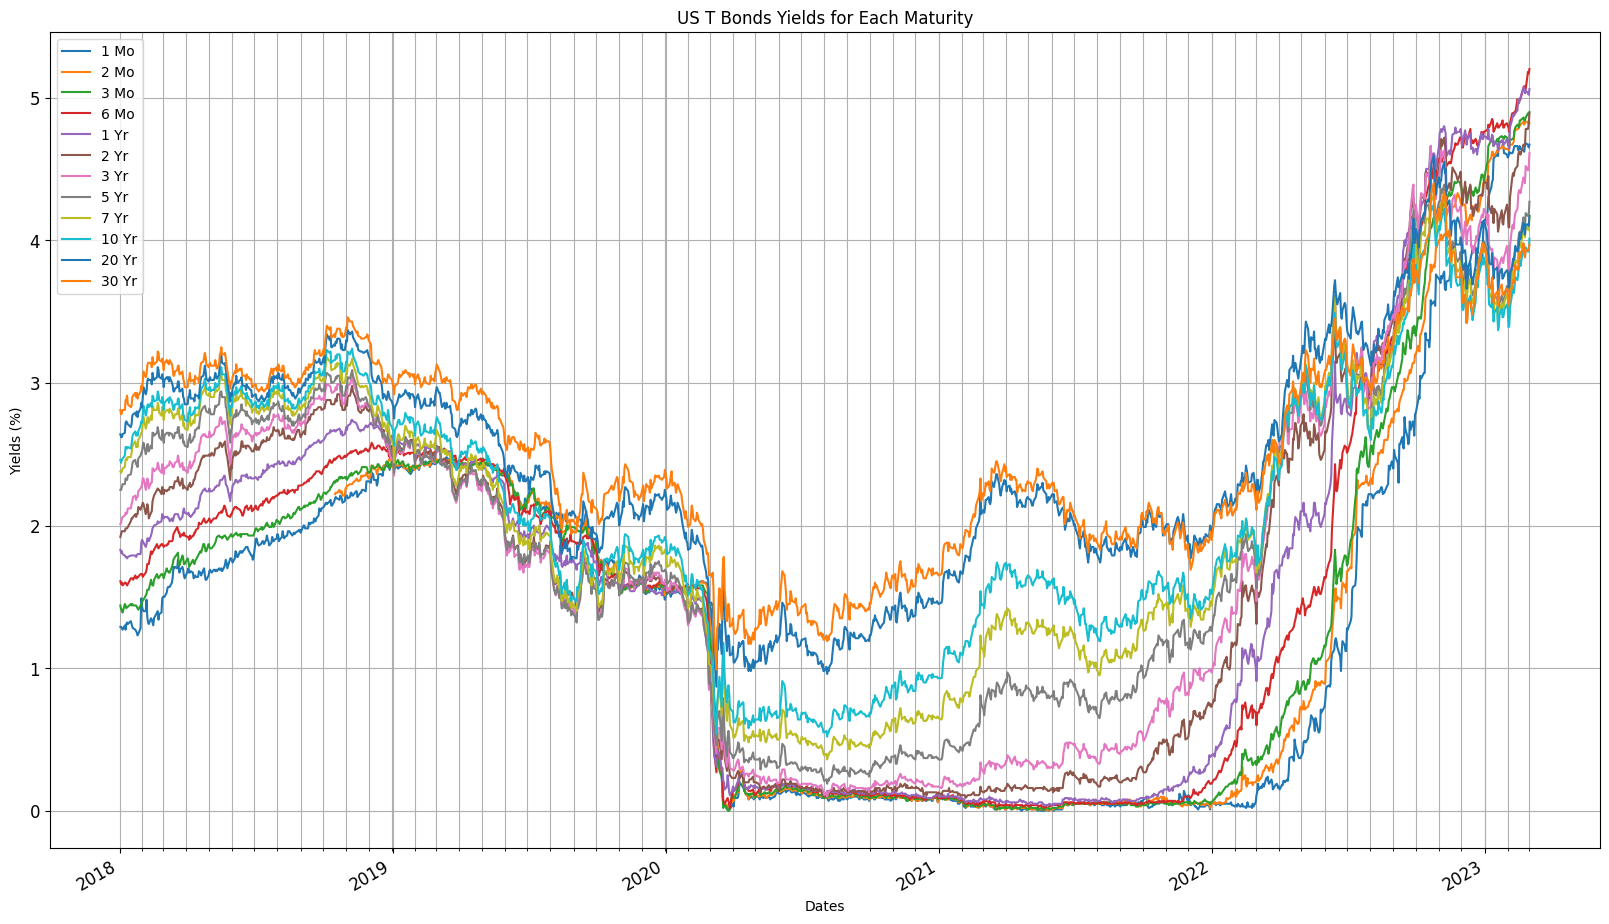

In [130]:
ax = yield_curves.plot(figsize=(20,12),grid=True,xlabel='Dates',ylabel='Yields (%)',
                  title='US T Bonds Yields for Each Maturity',fontsize=12)
xtick = pd.date_range( start=yield_curves.index.min( ), end=yield_curves.index.max( ), freq='M' )
ax.set_xticks( xtick, minor=True )
ax.grid('on', which='minor', axis='x' )

### Create Data Series

In [131]:
# print('Yield Data:')
# # display(yield_curve_df)
# yc_1 = yield_curve_df.copy(deep=True)
# yc_1['Date'] = pd.to_datetime(yc_1['Date'])
# yc_1 = yc_1.set_index('Date')
# # print(yc_1.index)
# for i in range(1,len(yc_1.columns)): 
#     yc_1.iloc[1:,i] = pd.to_numeric(yc_1.iloc[1:,i],errors='coerce') 
# # yc_1.info()
# yc_1_diff = round(yc_1.pct_change(periods=1)*100,3)
# yc_1_diff.dropna()
yield_curves.iloc[:8,4:]


,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,
2023-03-01,5.06,4.89,4.61,4.27,4.17,4.01,4.17,3.97
2023-02-28,5.02,4.81,4.51,4.18,4.07,3.92,4.10,3.93
2023-02-27,5.03,4.78,4.49,4.17,4.08,3.92,4.11,3.93
2023-02-24,5.05,4.78,4.52,4.19,4.10,3.95,4.11,3.93
2023-02-23,5.03,4.66,4.40,4.09,4.02,3.88,4.04,3.88
2023-02-22,5.07,4.66,4.43,4.13,4.07,3.93,4.09,3.94
2023-02-21,5.07,4.67,4.44,4.16,4.08,3.95,4.12,3.98
2023-02-17,5.00,4.60,4.33,4.03,3.95,3.82,4.01,3.88


### Check Long-End vs. Short End Crossing

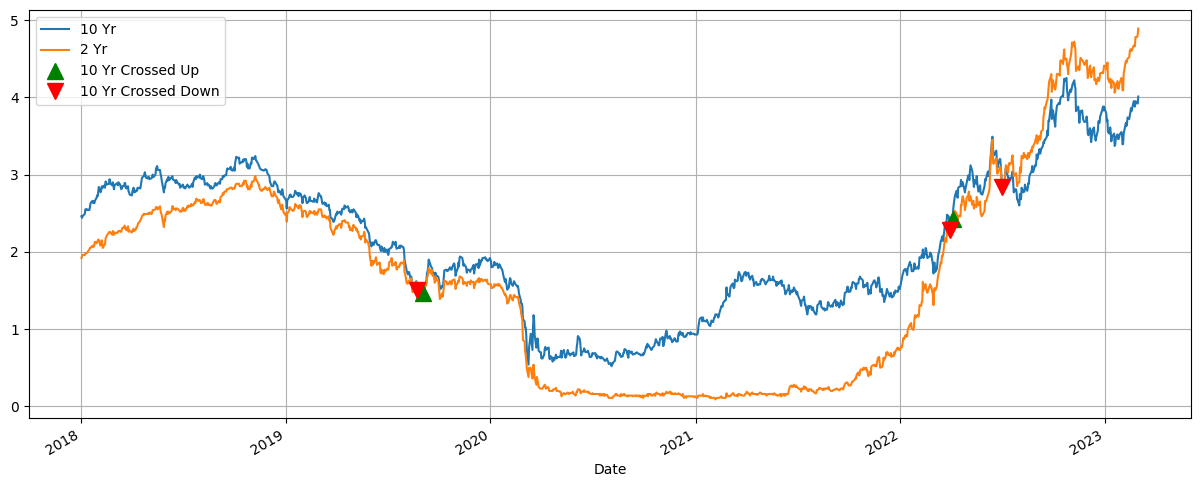

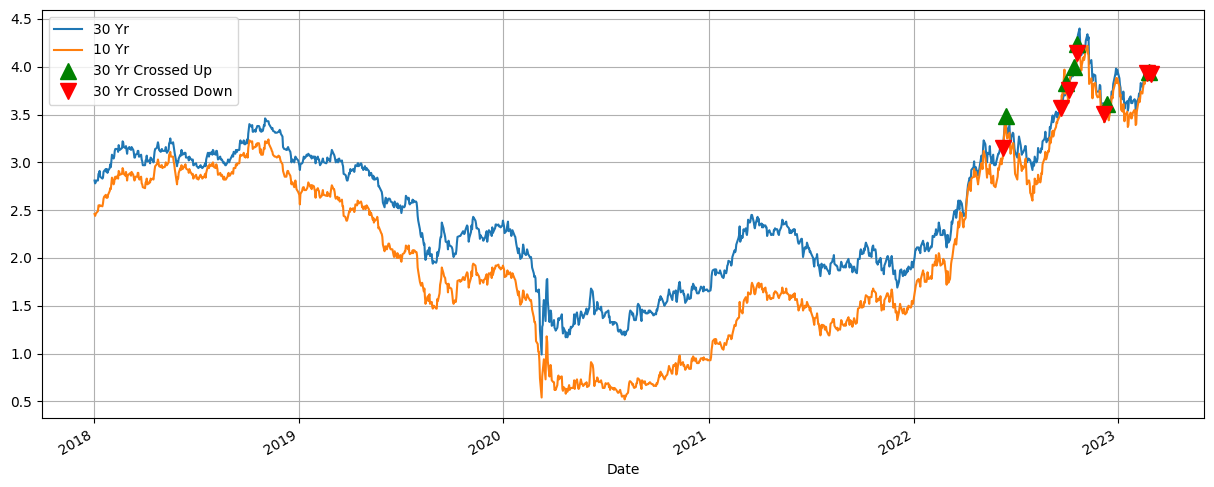

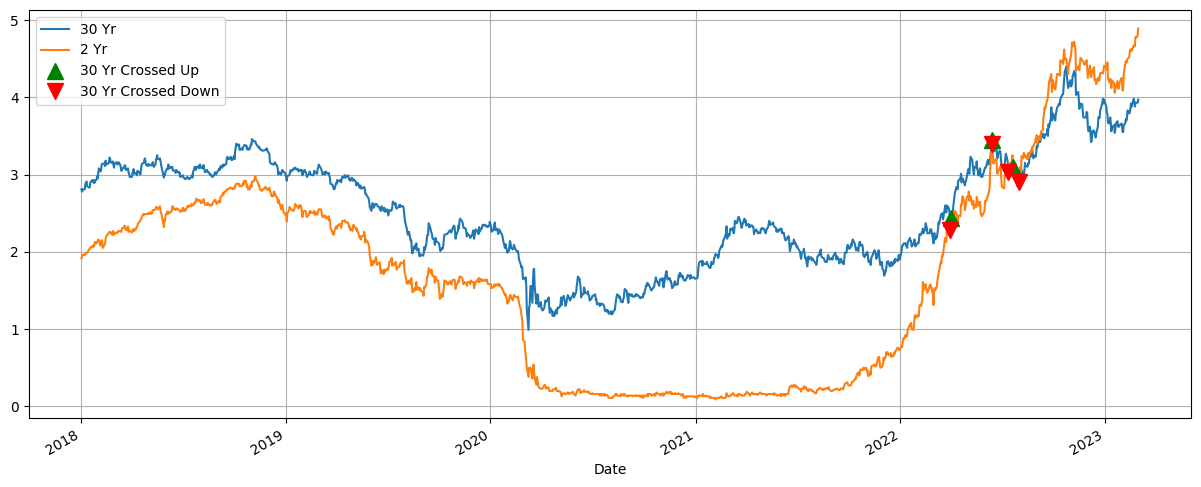

In [132]:
crossing_series, crossed_up, crossed_down=find_crossings(yield_curves['2 Yr'],yield_curves['10 Yr'])

plot_crossing_series(series2=yield_curves['2 Yr'],series1=yield_curves['10 Yr'],
                     crossed_up=crossed_up,crossed_down=crossed_down)
plt.show()

crossing_series, crossed_up, crossed_down=find_crossings(yield_curves['10 Yr'],yield_curves['30 Yr'])

plot_crossing_series(series2=yield_curves['10 Yr'],series1=yield_curves['30 Yr'],
                     crossed_up=crossed_up,crossed_down=crossed_down)
plt.show()


crossing_series, crossed_up, crossed_down=find_crossings(yield_curves['2 Yr'],yield_curves['30 Yr'])

plot_crossing_series(series2=yield_curves['2 Yr'],series1=yield_curves['30 Yr'],
                     crossed_up=crossed_up,crossed_down=crossed_down)
plt.show()

### Check for other Anomalies in the Long-Short Curves Data

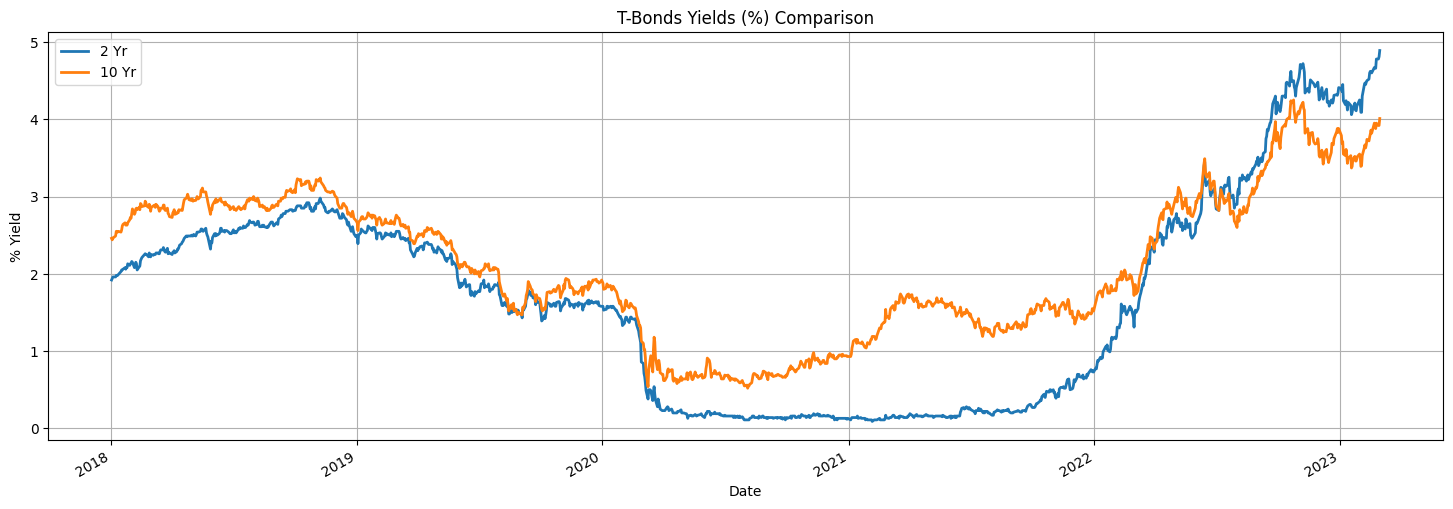

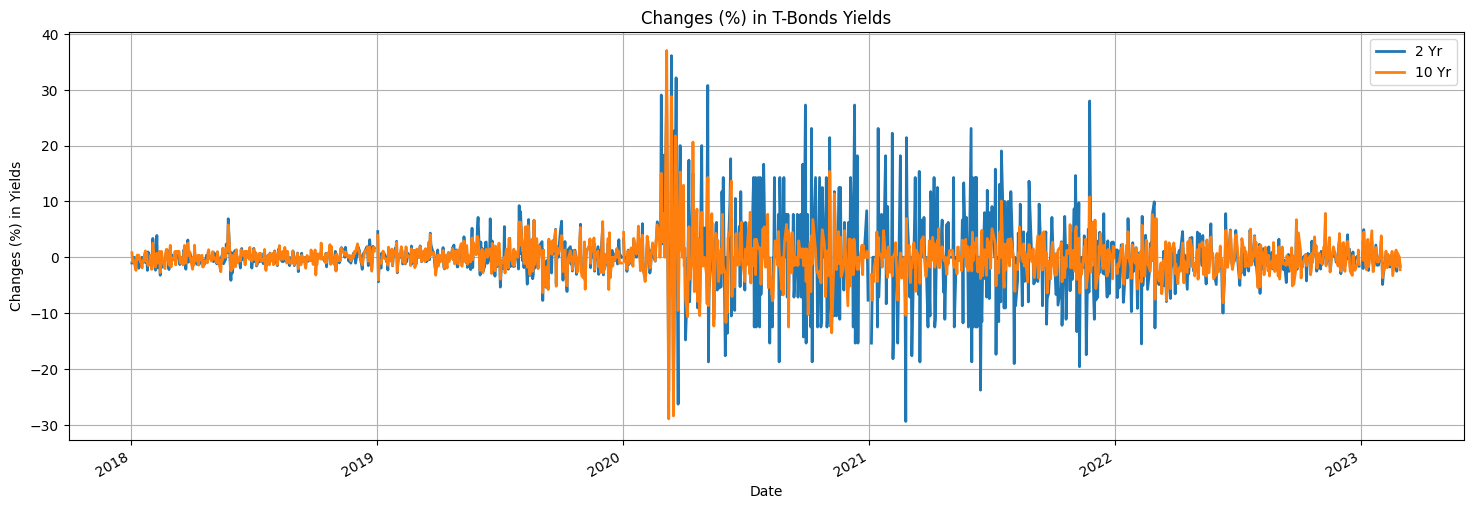

In [133]:

# Plot all
yield_curves[['2 Yr','10 Yr']].plot(figsize=(18,6),grid=True,
                            lw=2,xlabel='Date',ylabel='% Yield',
                            title="T-Bonds Yields (%) Comparison")
yield_curves_diff[['2 Yr','10 Yr']].plot(figsize=(18,6),grid=True,
                                 lw=2,xlabel='Date',ylabel='Changes (%) in Yields',
                                 title="Changes (%) in T-Bonds Yields")

plt.show()

### T-Bonds Vs. S&P 500 

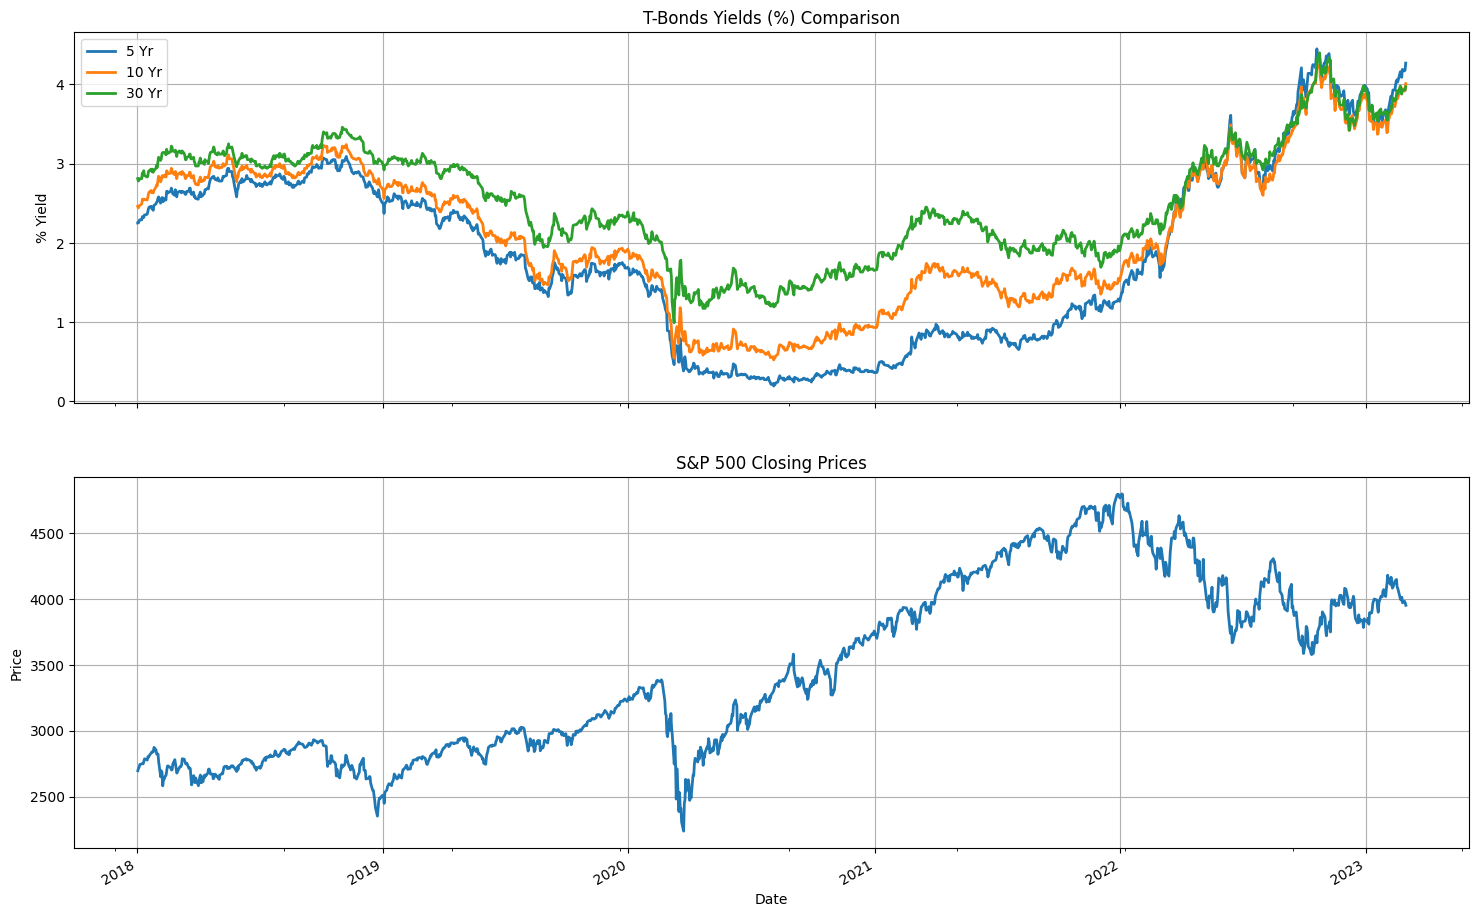

In [134]:

fig, ax = plt.subplots(2,1,figsize=(18,12),sharex=True)
yield_curves[['5 Yr','10 Yr','30 Yr']].plot(ax=ax[0],grid=True,
                            lw=2,xlabel='Date',ylabel='% Yield',
                            title="T-Bonds Yields (%) Comparison")

start_date = yield_curves.index[-1].strftime("%Y-%m-%d")
df_sp500 = yf.Ticker('^GSPC').history(start=start_date,interval='1d')['Close']


df_sp500.plot(ax=ax[1],grid=True,
                            lw=2,xlabel='Date',ylabel='Price',
                            title="S&P 500 Closing Prices")
plt.show()

S&P 500 Correlation with Bond Yields :
   Maturities  Correlations
0        1 Mo     -0.334675
1        2 Mo     -0.273682
2        3 Mo     -0.281359
3        6 Mo     -0.235173
4        1 Yr     -0.205636
5        2 Yr     -0.171549
6        3 Yr     -0.144732
7        5 Yr     -0.116736
8        7 Yr     -0.099968
9       10 Yr     -0.103433
10      20 Yr      0.002285
11      30 Yr     -0.114110


<AxesSubplot: title={'center': 'S&P 500 Prices Correlation with T Bond Yields'}, xlabel='T Bonds by Maturity', ylabel='Corr with S&P 500'>

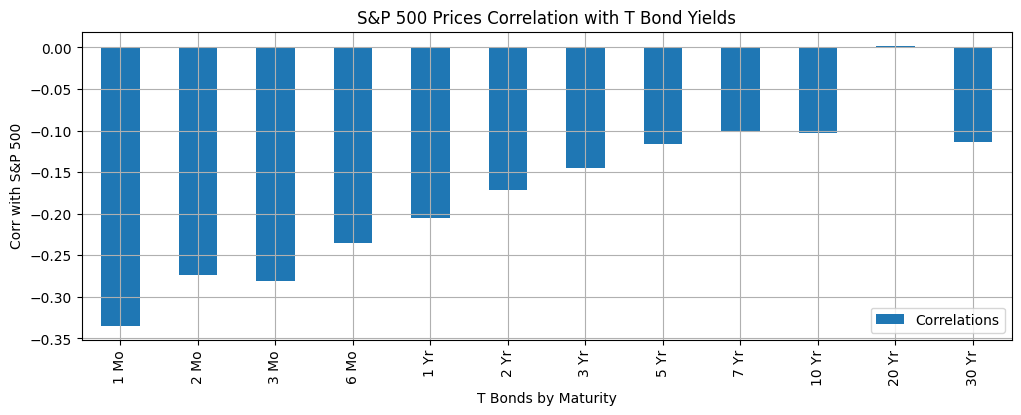

In [140]:
corr_with_bond = yield_curves.tz_localize('America/New_York').corrwith(df_sp500)
# corr_with_bond.values
corr_with_bond_df = pd.DataFrame({'Maturities':corr_with_bond.index,'Correlations':corr_with_bond.values})
print("S&P 500 Correlation with Bond Yields :")
print(corr_with_bond_df)
corr_with_bond_df.plot.bar(x='Maturities',y='Correlations',figsize=(12,4),
                           title="S&P 500 Prices Correlation with T Bond Yields",ylabel="Corr with S&P 500",
                           xlabel='T Bonds by Maturity',grid=True)

### Re-Formating and Cleaning the Data into a DataFrame

In [141]:
yield_curve_df2 = yield_curve_y0_df.reset_index()
yield_curve_df2 = yield_curve_df2.T
yield_curve_df2 = yield_curve_df2.reset_index()

yield_curve_df2 = yield_curve_df2.drop([0])
yield_curve_df2.iloc[0,0] = 'Maturity'
cols = [str(x) for x in yield_curve_df2.iloc[0,:]]

In [142]:
yield_curve_df2.columns = cols
yield_curve_df2 = yield_curve_df2.iloc[1:,:].copy()
yield_curve_df2.reset_index(inplace=True)
yield_curve_df2.drop(['index'],axis=1,inplace=True)
yield_curve_df2 = yield_curve_df2.set_index('Maturity')
yield_curve_df2

,03/01/2023,02/28/2023,02/27/2023,02/24/2023,02/23/2023,02/22/2023,02/21/2023,02/17/2023,02/16/2023,02/15/2023,...,01/17/2023,01/13/2023,01/12/2023,01/11/2023,01/10/2023,01/09/2023,01/06/2023,01/05/2023,01/04/2023,01/03/2023
Maturity,,,,,,,,,,,,,,,,,,,,,
1 Mo,4.67,4.65,4.67,4.68,4.66,4.62,4.63,4.64,4.66,4.64,...,4.6,4.58,4.57,4.42,4.41,4.37,4.32,4.3,4.2,4.17
2 Mo,4.82,4.81,4.83,4.83,4.83,4.81,4.83,4.81,4.8,4.79,...,4.63,4.59,4.59,4.62,4.62,4.58,4.55,4.55,4.42,4.42
3 Mo,4.9,4.88,4.89,4.86,4.84,4.84,4.86,4.84,4.84,4.79,...,4.71,4.67,4.66,4.72,4.73,4.7,4.67,4.66,4.55,4.53
6 Mo,5.2,5.17,5.18,5.06,5.05,5.08,5.07,4.99,4.98,4.97,...,4.82,4.77,4.76,4.84,4.85,4.83,4.79,4.81,4.77,4.77
1 Yr,5.06,5.02,5.03,5.05,5.03,5.07,5.07,5.0,4.99,4.96,...,4.67,4.69,4.66,4.73,4.74,4.69,4.71,4.78,4.71,4.72
2 Yr,4.89,4.81,4.78,4.78,4.66,4.66,4.67,4.6,4.62,4.62,...,4.18,4.22,4.12,4.2,4.24,4.19,4.24,4.45,4.36,4.4
3 Yr,4.61,4.51,4.49,4.52,4.4,4.43,4.44,4.33,4.35,4.35,...,3.86,3.88,3.79,3.9,3.94,3.93,3.96,4.18,4.11,4.18
5 Yr,4.27,4.18,4.17,4.19,4.09,4.13,4.16,4.03,4.06,4.04,...,3.6,3.6,3.53,3.66,3.72,3.66,3.69,3.9,3.85,3.94
7 Yr,4.17,4.07,4.08,4.1,4.02,4.07,4.08,3.95,3.98,3.94,...,3.57,3.55,3.48,3.61,3.67,3.6,3.63,3.82,3.79,3.89


### Plot the Most Recent Yield Curves

In [143]:
longest_n_maturities = 8   # For ALL maturities set = len(yield_curve_df2)
last_n_days = 5            # For ALL days in the data set = -1
fig = px.line(yield_curve_df2.iloc[-longest_n_maturities:,:last_n_days],markers=True)

fig.update_layout(
    width=1200,
    height=600,
   title="US Treasury Bonds Yield Curve",
   xaxis_title='Bond Maturity',
   yaxis_title='Interest Rate %',
   legend_title="Curve Date",
   font=dict(
      family="Arial",
      size=20,
      color="blue"
   )
)
fig.show()

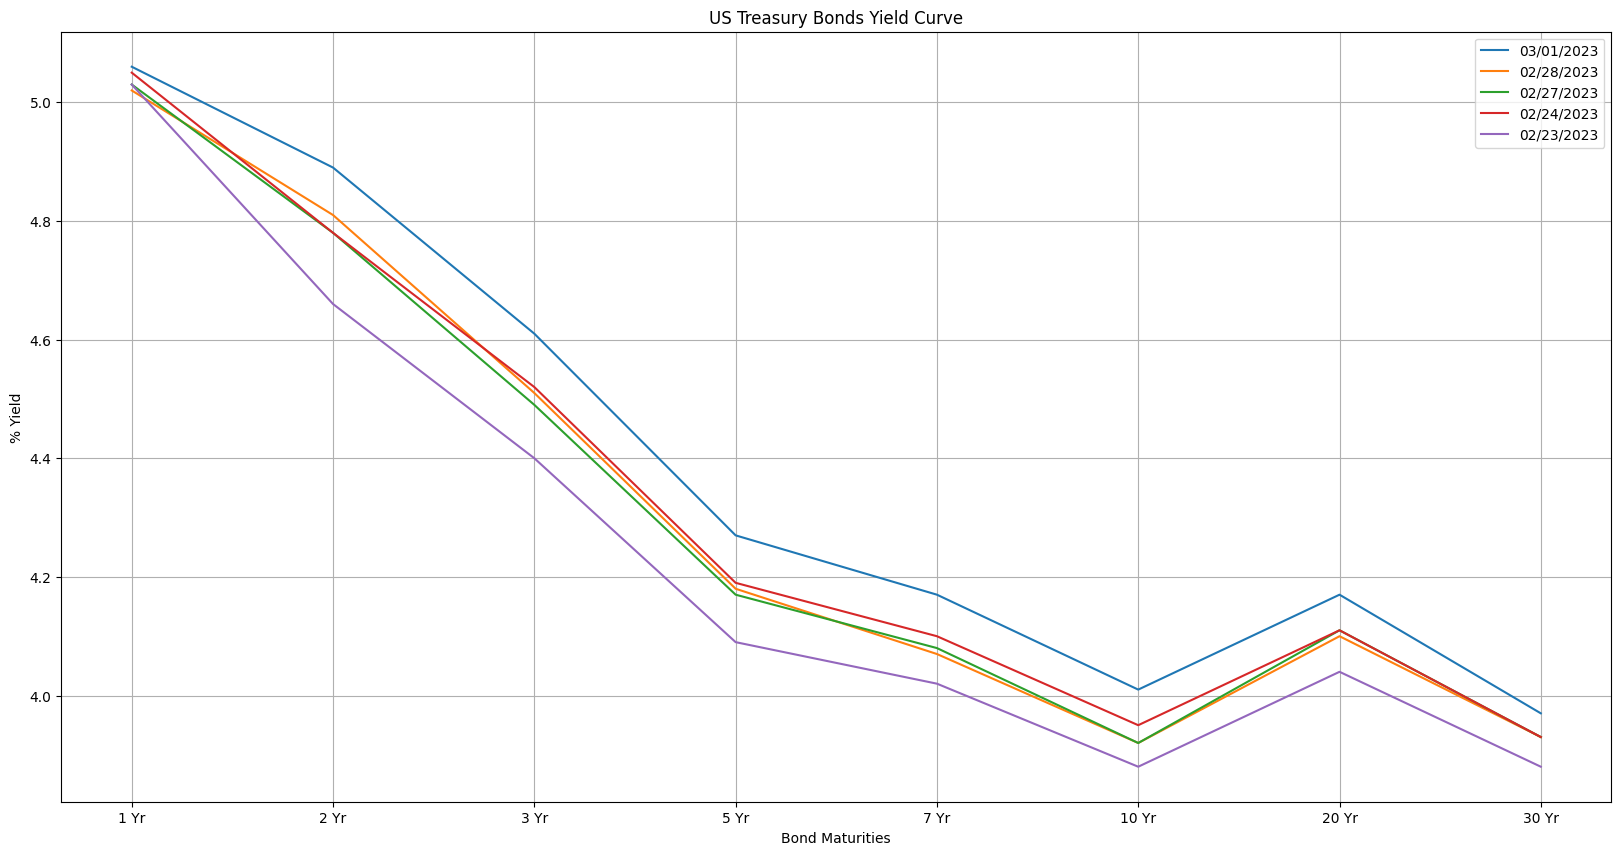

In [144]:
yield_curve_df2.iloc[-8:,:5].plot(figsize=(20,10),title="US Treasury Bonds Yield Curve",ylabel='% Yield',
                     xlabel='Bond Maturities',grid=True)
plt.show()